In [2]:
# load libraries
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

%matplotlib inline  
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [3]:
#load data
data = loadmat('./data/ex4data1.mat')
X,y=data['X'],data['y']
weights = loadmat('data/ex4weights.mat')
given_theta_tuple = (weights['Theta1'], weights['Theta2'])
# pack the weights into a single data structure to generalize
#X  (5000, 400)
#y  (5000, 1)
#theta1  (25, 401)
#theta2  (10, 26)

In [4]:
# expand y
N_neuron = (400,25,10) # number of neurons in each hidden layer: input, hidden (could be larger than 1), output
y_ext=np.zeros((y.size,N_neuron[-1]))
for k in range(N_neuron[-1]):
    y_ext[:,k]=(y==k+1).astype(int).flatten()

In [5]:
# a function to unpack weights as a vector from a tuple
def unpackTheta(theta_tuple):
    theta_vector=[]
    for theta_tuple_i in theta_tuple:
        theta_vector=np.r_[theta_vector,(theta_tuple_i.flatten())]
    return(theta_vector)

# a function to pack weiths as a vector to a tuple
def packTheta(theta_vector,N_neuron):
    theta_tuple=()
    start_index=0
    for layer in range(len(N_neuron)-1):
        local_weights=np.array(theta_vector[start_index:start_index+(N_neuron[layer]+1)*N_neuron[layer+1]])
        theta_tuple+=(local_weights.reshape(N_neuron[layer+1],N_neuron[layer]+1),)
        start_index=(N_neuron[layer]+1)*N_neuron[layer+1]
    return(theta_tuple)

In [6]:
# forward propogation, with theta an vector
def predict(theta_vector,N_neuron,X):
    # transfer weights
    theta_tuple=packTheta(theta_vector,N_neuron)
    # initialize
    X_i=np.c_[np.ones(X.shape[0]),X]
    z_output=(X_i.T,)
    y_output=(X_i,)
    # a loop to calculate different layers
    for i,theta_i in enumerate(theta_tuple):
        z_i=X_i.dot(theta_i.T)
        if i < len(theta_tuple)-1:
            y_i=np.c_[np.ones(z_i.shape[0]),sp.special.expit(z_i)]
        else:
            y_i=np.c_[sp.special.expit(z_i)]
        z_output+=(z_i.T,)
        y_output+=(y_i,)
        X_i=y_i    
    return((z_output,y_output))

In [7]:
given_theta_vector=unpackTheta(given_theta_tuple)
z_output,y_output=predict(given_theta_vector,N_neuron,X)
y_pre=np.argmax(y_output[-1],axis=1)+1

print('97.52 as accurate answer')
print(np.sum((y_pre==y.flatten()).astype(int))/np.size(y)*100)

97.52 as accurate answer
97.52


In [10]:
# cost function
def costFunction(theta_vector,N_neuron,reg,X,y_ext):
    z_output,y_output=predict(theta_vector,N_neuron,X)
    theta_tuple=packTheta(theta_vector,N_neuron)
    m=np.shape(y_output[-1])[0]
    J=1/m*np.sum(-y_ext*np.log(y_output[-1])-(1-y_ext)*np.log(1-y_output[-1]))
    for theta_i in theta_tuple:
        J+=np.sum(np.square(theta_i))/(2*m)*reg
    if np.isnan(J):
        return(np.inf)
    return(J)
reg=1
cost=costFunction(given_theta_vector,N_neuron,reg,X,y_ext)

print('0.28762916516131892 as accurate answer')
print(cost)

0.28762916516131892 as accurate answer
0.384487796243


In [11]:
def sigmoidFunction(z):
    return(1/(1+np.exp(-z)))
def sigmoidGradient(z):
    y=sigmoidFunction(z)
    return(y*(1-y))

In [12]:
# initialize the NN
#N_neuron = (400,25,10) # number of neurons in each hidden layer
#X  (5000, 400)
#y  (5000, 1)
#theta1  (25, 401)
#theta2  (10, 26)
epsilon = 0.12
initial_theta_tuple=()
for i in range(len(N_neuron)-1):
    initial_theta_tuple+=(np.random.uniform(
            -epsilon,epsilon,(N_neuron[i+1],N_neuron[i]+1)),)
initial_theta_vector=unpackTheta(initial_theta_tuple)

In [18]:
# back propogation
def gradFunction(theta_vector,N_neuron,reg,X,y_ext):
    # number of hidden layers
    N_hidden = len(N_neuron)-2    
    # wrap up weights
    theta_tuple=packTheta(theta_vector,N_neuron)    
    # initialize the gradient function
    m=np.shape(X)[0]
    DELTA = []
    for layer in range(N_hidden+1):
        DELTA.append(0)        
    # t is the index of each training sample    
    for t in range(m):   
        # forward propogation
        z_output,y_output = predict(theta_vector,N_neuron,X[t,:].reshape(1,-1))           
        # calculate delta terms
        delta=(y_output[-1]-y_ext[t,:]).T
        DELTA[-1]+=delta.dot(y_output[-2]) 
        for layer in range(N_hidden):
            delta=theta_tuple[-(layer+1)][:,1:].T.dot(delta.reshape(-1,1))*sigmoidGradient(z_output[-(layer+2)]).reshape(-1,1)
            DELTA[-(layer+2)]+=delta.dot(y_output[-(layer+3)].reshape(1,-1))            
    # divide by number of training samples
    for DELTA_i in DELTA:
        DELTA_i/=m    
    # add regulation terms
    DELTA[-1]+=reg/m*np.c_[np.zeros(np.shape(theta_tuple[-1])[0]),theta_tuple[-1][:,1:]]
    for layer in range(N_hidden):
        DELTA[-(layer+2)]+=reg/m*np.c_[np.zeros(np.shape(theta_tuple[-(layer+2)])[0]),theta_tuple[-(layer+2)][:,1:]]
    # put the gradient into a vector    
    DELTA_vector=unpackTheta(DELTA)
    return(DELTA_vector)
#grad=gradFunction(initial_theta_vector,N_neuron,reg,X,y_ext)

In [23]:
# minimalize cost function
res = sp.optimize.minimize(costFunction,initial_theta_vector,args=(N_neuron,reg,X,y_ext),
                                   jac=gradFunction,method=None,options={'maxiter':400})
trained_theta_vector=res.x
trained_theta_tuple=packTheta(trained_theta_vector,N_neuron)

In [24]:
res

      fun: 0.35386220536842633
 hess_inv: array([[  3.51249414e+00,  -7.24875325e-02,  -7.04291793e-02, ...,
         -5.24027050e-01,   4.36834735e-02,   1.23040587e+00],
       [ -7.24875325e-02,   1.00300683e+00,   2.92144678e-03, ...,
          2.82216590e-02,   6.50387245e-04,  -3.31180716e-02],
       [ -7.04291793e-02,   2.92144678e-03,   1.00283849e+00, ...,
          2.74202779e-02,   6.31918874e-04,  -3.21776521e-02],
       ..., 
       [ -5.24027050e-01,   2.82216590e-02,   2.74202779e-02, ...,
          5.08566821e+00,  -7.18157246e-01,  -2.68400957e+00],
       [  4.36834735e-02,   6.50387245e-04,   6.31918874e-04, ...,
         -7.18157246e-01,   1.86820288e+00,   6.40972502e-01],
       [  1.23040587e+00,  -3.31180716e-02,  -3.21776521e-02, ...,
         -2.68400957e+00,   6.40972502e-01,   6.82097065e+00]])
      jac: array([  1.49139759e-04,  -5.33704557e-08,  -5.18549503e-08, ...,
        -2.50830170e-04,   2.23179724e-05,  -2.15764284e-04])
  message: 'Desired error

In [25]:
# make prediction
z_output,y_output=predict(trained_theta_vector,N_neuron,X)
y_pre=np.argmax(y_output[-1],axis=1)+1

print('97.52 is the given weights')
print(np.sum((y_pre==y.flatten()).astype(int))/np.size(y)*100)

97.52 is the given weights
99.16


[10  2  9  2  4  1  5  3  1 10]
[[10  2  9  2  4  1  5  3  1 10]]


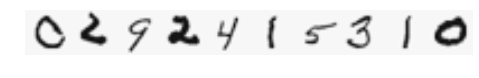

In [27]:
# plot
# show the digits and compare with our prediction
# get 10 random samples
sample=np.random.choice(X.shape[0],10)
plt.imshow(X[sample].reshape(-1,20).T)
plt.axis('off');
print(y_pre[sample].T)
print(y[sample].T)

In [28]:
# save the trained weights
np.savetxt('trained_theta_vector_99.16.txt',trained_theta_vector, delimiter=' ')